# Exploratory Analysis of Automatically Generated Text Corpus

In [29]:
# Imports
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.metrics.oov_words import OOVWords
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer

import pandas as pd

from tqdm.notebook import tqdm

import string

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%pwd

'/mnt/rufus_A/multimemo/notebooks'

In [2]:
# Load data
data = pd.read_json('../data/processed/memento_data_recaption.json')
data_exp = data.explode(['captions', 'recaptions'], ignore_index=True)
print(f"Loaded {len(data_exp)} captions.")

Loaded 42500 captions.


In [12]:
# Remove punctuation

def remove_punctuation(text):
    """
    Remove punctuation from a text.
    """
    return text.translate(str.maketrans('', '', string.punctuation))

data_exp['captions'] = data_exp['captions'].apply(remove_punctuation)
data_exp['recaptions'] = data_exp['recaptions'].apply(remove_punctuation)


## OOV words

In [13]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
device = "gpu"

oov_metric = OOVWords(model, tokenizer, device)

In [14]:
data_exp['caption_oov_words'] = oov_metric.get_metric(data_exp['captions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp)} captions.")
print(f"Sample caption OOV: {data_exp['caption_oov_words'].values[:5]}")
data_exp['recaption_oov_words'] = oov_metric.get_metric(data_exp['recaptions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp)} recaptions.")
print(f"Sample recaption OOV: {data_exp['recaption_oov_words'].values[:5]}")

OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

OOV words: 100%|██████████| 42500/42500 [00:19<00:00, 2169.90it/s]


Successfully computed OOV for 42500 captions.
Sample caption OOV: [2 0 0 1 0]


OOV words: 100%|██████████| 42500/42500 [00:20<00:00, 2052.28it/s]

Successfully computed OOV for 42500 recaptions.
Sample recaption OOV: [0 1 1 1 1]


In [15]:
high_oov_captions = data_exp[data_exp['caption_oov_words'] > 0]
high_oov_captions[['captions', 'caption_oov_words']].head(10)

,captions,caption_oov_words
0,A brown hair girl with lip piercings mumbles s...,2
3,A young woman wearing a striped shirt who has ...,1
10,A person wearing a white sleeveless shirt is c...,1
11,A fat woman claps and hits the table while spe...,1
12,A larger woman in a white tank top claps her h...,1
14,A brunette sings and claps before in front of ...,1
20,Two overweight women sway next to each other a...,1
22,Two morbidly obese women dance and sing in a r...,2
24,two fatties stand around and sing while swayin...,1
36,The lower part of a womans face neck and shoul...,1


In [23]:
tokenizer.tokenize(high_oov_captions['captions'].iloc[6])

['two',
 'over',
 '##weight',
 'women',
 'sway',
 'next',
 'to',
 'each',
 'other',
 'as',
 'one',
 'of',
 'them',
 'sings']

In [25]:
no_oov = data_exp[data_exp['caption_oov_words'] == 0]
print(no_oov.shape)

(28780, 13)


In [28]:
# Percentage of OOV words in the captions and recaptions corpus
total_words_in_captions_corpus = 0
total_oov_words_in_captions_corpus = 0
total_words_in_recaptions_corpus = 0
total_oov_words_in_recaptions_corpus = 0
for _, row in tqdm(data_exp.iterrows(), total=data_exp.shape[0], desc="OOV words"):
    total_words_in_captions_corpus += len(row['captions'].split())
    total_words_in_recaptions_corpus += len(row['recaptions'].split())
    total_oov_words_in_captions_corpus += row['caption_oov_words']
    total_oov_words_in_recaptions_corpus += row['recaption_oov_words']
print(f"Percentage of OOV words in the captions corpus: {total_oov_words_in_captions_corpus/total_words_in_captions_corpus*100:.2f}%")
print(f"Percentage of OOV words in the recaptions corpus: {total_oov_words_in_recaptions_corpus/total_words_in_recaptions_corpus*100:.2f}%")


OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

Percentage of OOV words in the captions corpus: 2.98%
Percentage of OOV words in the recaptions corpus: 9.89%


In [31]:
data_exp[['caption_oov_words', 'recaption_oov_words']].describe()

,caption_oov_words,recaption_oov_words
count,42500.000000,42500.000000
mean,0.390165,1.338376
std,0.625585,1.152594
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,6.000000,10.000000


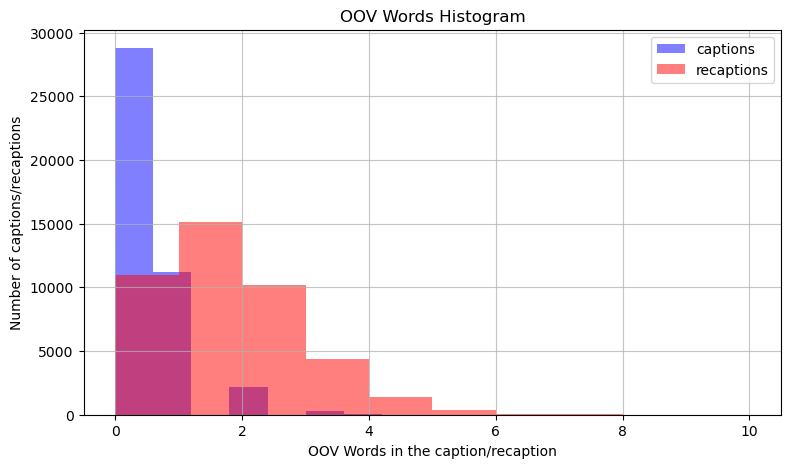

In [33]:
# Histogram of the OOV words for the captions and recaptions corpus (same plot)

plt.figure(figsize=(9, 5))
plt.hist(data_exp['caption_oov_words'], bins=10, alpha=0.5, label='captions', density=False, color='blue')
plt.hist(data_exp['recaption_oov_words'], bins=10, alpha=0.5, label='recaptions', density=False, color='red')
plt.legend(loc='upper right')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('OOV Words in the caption/recaption')
plt.ylabel('Number of captions/recaptions')
plt.title('OOV Words Histogram')
plt.show()

In [45]:
data_exp['caption_length'] = data_exp['captions'].apply(lambda x: len(x.split()))
data_exp['caption_oov_words_ratio'] = data_exp['caption_oov_words'] / data_exp['caption_length']

data_exp['recaption_length'] = data_exp['recaptions'].apply(lambda x: len(x.split()))
data_exp['recaption_oov_words_ratio'] = data_exp['recaption_oov_words'] / data_exp['recaption_length']

data_exp[['caption_oov_words_ratio', 'recaption_oov_words_ratio']].describe()

,caption_oov_words_ratio,recaption_oov_words_ratio
count,42500.000000,42500.000000
mean,0.030617,0.103267
std,0.049828,0.090813
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.086957
75%,0.071429,0.153846
max,0.400000,0.800000


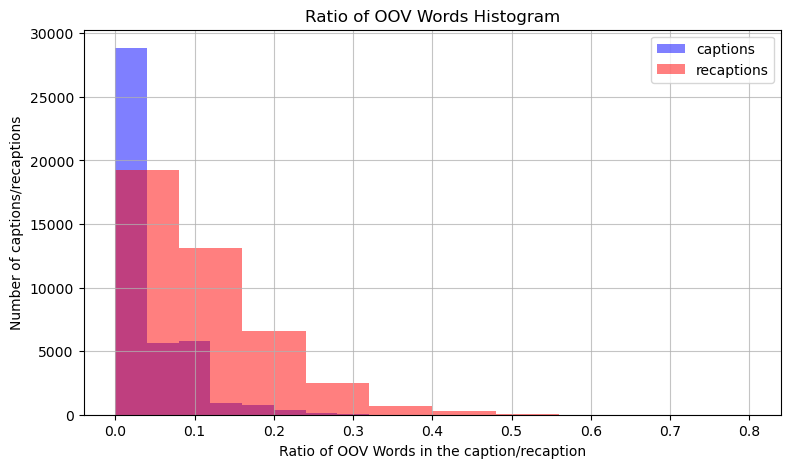

In [46]:
plt.figure(figsize=(9, 5))
plt.hist(data_exp['caption_oov_words_ratio'], bins=10, alpha=0.5, label='captions', density=False, color='blue')
plt.hist(data_exp['recaption_oov_words_ratio'], bins=10, alpha=0.5, label='recaptions', density=False, color='red')
plt.legend(loc='upper right')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('Ratio of OOV Words in the caption/recaption')
plt.ylabel('Number of captions/recaptions')
plt.title('Ratio of OOV Words Histogram')
plt.show()

In [42]:
# Show recaptions examples with most OOV words
highest_oov_recaptions = data_exp[['recaptions','recaption_oov_words']].sort_values(by='recaption_oov_words', ascending=False).head(10)
highest_oov_recaptions

,recaptions,recaption_oov_words
25451,A wintry set of scenes filled with snowdriftin...,10
35244,A late night adventurer glides effortlessly up...,10
8329,A car winds its way through scorching sand dun...,9
35499,A group unwinds amidst the warmth of a burning...,9
39195,Un billet dune course nautique avec plusieurs ...,9
25359,A cute feline naps on a cozy beanbag then hila...,8
21264,Musicians donning cowboy hats grace the stage ...,8
9796,A tiny cherub nestled merrily within a comfy p...,8
36614,A school of shimmering fish glides amidst wave...,8
312,A tiny tot licks and slobbers over a toweldeck...,8


In [43]:
tokenizer.tokenize(highest_oov_recaptions['recaptions'].values[0])

['a',
 'win',
 '##try',
 'set',
 'of',
 'scenes',
 'filled',
 'with',
 'snow',
 '##dr',
 '##if',
 '##ting',
 'heavily',
 '##car',
 '##pet',
 '##ed',
 'cobb',
 '##led',
 'roads',
 'lit',
 'up',
 'by',
 'a',
 'charming',
 'collection',
 'of',
 'diverse',
 'residents',
 'o',
 '##cc',
 '##lus',
 '##ive',
 '##lo',
 '##oki',
 '##ng',
 'residences',
 'parallel',
 '##ed',
 'with',
 'ob',
 '##st',
 '##ru',
 '##cting',
 'driveway',
 '##s',
 'fence',
 '##d',
 'up',
 'by',
 'contrasting',
 'eccentric',
 'winter',
 '##cha',
 '##rio',
 '##t',
 'bars',
 'surrounded']